In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

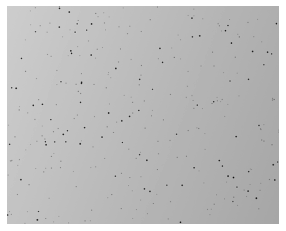

In [27]:
moving_plankton = moving_spherical_plankton(im_size_height=512, 
                                            im_size_width=640, 
                                            radius=0.4e-6, 
                                            label=1, 
                                            diffusion_constant_coeff=1.3)

stationary_plankton = stationary_spherical_plankton(im_size_height=512, 
                                                    im_size_width=640, 
                                                    radius=0.2e-6, 
                                                    label=2)

sequential_moving_plankton = Sequential(moving_plankton, position=get_position_moving_plankton)
sequential_stationary_plankton = Sequential(stationary_plankton, position=get_position_stationary_plankton)

microscope = plankton_brightfield(im_size_height=512, 
                                  im_size_width=640, 
                                  gradient_amp=0.1)

no_of_moving_planktons, no_of_stationary_planktons = 80, 200

sample = create_sample(sequential_moving_plankton, no_of_moving_planktons, 
                       sequential_stationary_plankton, no_of_stationary_planktons) 

noise_amp = 0.1
norm_min, norm_max= 0, 1
sequence = create_sequence(noise_amp, sample, microscope, norm_min, norm_max)

sequence_length = 2
imaged_particle_sequence = Sequence(sequence, sequence_length=sequence_length)

imaged_particle_sequence.plot(cmap='gray')

In [28]:
resolved_sequence = imaged_particle_sequence.resolve()

In [36]:
def get_target_sequence(sequence_of_particles):
    no_of_types = 1
    for property in sequence_of_particles[0].properties:
        if "particle_type" in property:
            no_of_types = max(property['particle_type'] + 1, no_of_types)
    if no_of_types==1:
        indices = np.asarray(sequence_of_particles).shape[0]
        label = np.zeros((*np.asarray(sequence_of_particles).shape[1:3], indices + 1))
        
        X, Y = np.meshgrid(
            np.arange(0, np.asarray(sequence_of_particles).shape[2]), 
            np.arange(0, np.asarray(sequence_of_particles).shape[1])
        )
        for i in range(indices):
            for property in sequence_of_particles[i].properties:
                if "position" in property:
                    position = property["position"]
                    distance_map = (X - position[1])**2 + (Y - position[0])**2
    
                    label[distance_map < 3, (property["particle_type"] + 1) * (i+1)] = 1
        label[..., 0] = 1 - np.max(label[..., 1:], axis=-1)
    else:
        indices = np.asarray(sequence_of_particles).shape[0]
        label = np.zeros((*np.asarray(sequence_of_particles).shape[1:3], no_of_types + 1))
        
        X, Y = np.meshgrid(
            np.arange(0, np.asarray(sequence_of_particles).shape[2]), 
            np.arange(0, np.asarray(sequence_of_particles).shape[1])
        )
        segmentation_image = int(indices/2)
        for property in sequence_of_particles[segmentation_image].properties:
            if "position" in property:
                position = property["position"]
                distance_map = (X - position[1])**2 + (Y - position[0])**2

                label[distance_map < 3, (property["particle_type"] + 1)] = 1
        label[..., 0] = 1 - np.max(label[..., 1:], axis=-1)
        
    return label


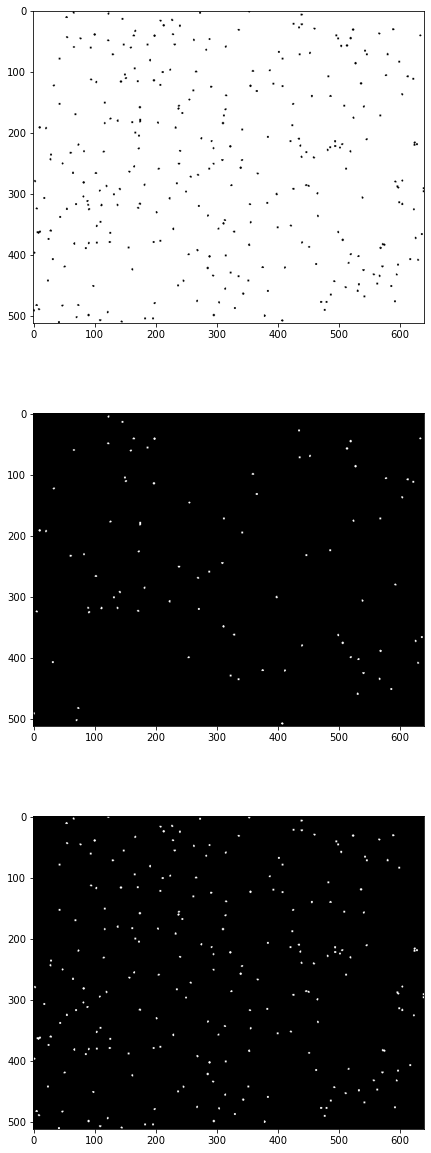

In [37]:
label = get_target_sequence(resolved_sequence)
label_function = get_target_sequence
plot_label(label_function, imaged_particle_sequence)

In [ ]:
batch_function = create_custom_batch_function(imaged_particle_sequence, 
                                              outputs=[0,1,2], 
                                              function_img=[Normalize_image],
                                              function_diff=[Normalize_image])


train_images = batch_function(imaged_particle_sequence.resolve())

plot_batch(train_images)

In [ ]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    imaged_particle_sequence,
    get_target_sequence,
    batch_function,
    batch_size=8,
    min_data_size=80,
    max_data_size=512
    )

In [ ]:
model = generate_unet(im_size_height=512, im_size_width=640, no_of_inputs=3, number_of_outputs=4)

In [ ]:
model = train_model(model, generator, patience=20, epochs=50, steps_per_epoch=10)

In [ ]:
# change outputs
im_stack = get_image_stack(outputs=[0, 1, 2], 
                           folder_path = 'E:\Documents\Anaconda\Jupyterkod\Exjobb\Egen kod\Exjobb\From erik\\alexandrium2', 
                           frame_im0 = 39, 
                           im_size_width = 640, 
                           im_size_height = 512,
                           function_img=[Normalize_image], 
                           function_diff=[Normalize_image])

# plot_im_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,1], cmap='gray')

In [ ]:
positions = extract_positions(
    no_of_frames = 10, 
    outputs=[0,1,2], 
    folder_path = 'E:\Documents\Anaconda\Jupyterkod\Exjobb\Egen kod\Exjobb\From erik\\alexandrium2', 
    frame_im0 = 39, 
    im_size_width = 640, 
    im_size_height = 512,
    model = model, 
    layer = 2, 
    value_threshold=0.4,
    function_img=[Normalize_image], 
    function_diff=[Normalize_image])


In [ ]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=25, threshold = 11, extrapolate=True)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=25)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0, list_of_plankton=list_of_plankton)

In [ ]:
plot_and_save_track(no_of_frames = len(list_of_plankton[list(list_of_plankton.keys())[0]].positions),
                    plankton_track = plankton_track,
                    plankton_dont_track = plankton_dont_track,
                    folder_path = 'E:\Documents\Anaconda\Jupyterkod\Exjobb\Egen kod\Exjobb\From erik\\alexandrium2',
                    frame_im0 = 40,
                    save_images=False,
                    show_plankton_track = True,
                    show_plankton_dont_track = True,
                    show_numbers_track = True,
                    show_numbers_dont_track = True,
                    show_numbers_specific_plankton = False,
                    show_specific_plankton = False,
                    specific_plankton = None,
                    color_plankton_track = 'b',
                    color_plankton_dont_track = 'r',
                    color_specific_plankton = 'w',
                    save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output',
                    frame_name = 'track',
                    file_type = '.jpg')

In [ ]:
list_of_plankton